# Anomaly Detection

---

### Key Idea:
- Detect anomalies (good/bad) so that studios can know which animes to model after or not model after in order to maximise profits

---

### Essential Libraries

Let us begin by importing the essential Python Libraries.

> NumPy : Library for Numeric Computations in Python  
> Pandas : Library for Data Acquisition and Preparation  
> Matplotlib : Low-level library for Data Visualization  
> Seaborn : Higher-level library for Data Visualization  

In [1]:
# Basic Libraries
import json
import statistics
import math

from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt  # we only need pyplot

sb.set()  # set the default Seaborn style for graphics

import warnings
warnings.filterwarnings('ignore')

## Importing the data

In [10]:
anime_df = pd.read_csv('dataset/anime_cleaned_2.csv')
print("Number of animes:", len(anime_df))
anime_df.head(1)

Number of animes: 8661


,id,title,start_date,end_date,synopsis,mean,rank,popularity,num_list_users,num_scoring_users,...,broadcast_day_of_the_week,broadcast_start_time,statistics_watching,statistics_completed,statistics_on_hold,statistics_dropped,statistics_plan_to_watch,statistics_num_list_users,positive_viewership_fraction,negative_viewership_fraction
0,95,Turn A Gundam,1999-04-09,2000-04-14,"It is the Correct Century, two millennia after...",7.71,1049,2892,40743,13338,...,friday,17:00,2735.0,16661.0,2538.0,1597.0,17292.0,40823.0,0.8987,0.1013


In [11]:
anime_df.columns

Index(['id', 'title', 'start_date', 'end_date', 'synopsis', 'mean', 'rank',
       'popularity', 'num_list_users', 'num_scoring_users', 'nsfw',
       'media_type', 'status', 'genres', 'num_episodes', 'source',
       'average_episode_duration', 'rating', 'studios', 'start_season_year',
       'start_season_season', 'broadcast_day_of_the_week',
       'broadcast_start_time', 'statistics_watching', 'statistics_completed',
       'statistics_on_hold', 'statistics_dropped', 'statistics_plan_to_watch',
       'statistics_num_list_users', 'positive_viewership_fraction',
       'negative_viewership_fraction'],
      dtype='object')

### Drop not essential columns like `id` and `date`
- As date/year will only keep on increasing as time passes

In [12]:
anime_df.drop(columns=['id', 'start_date', 'end_date', 'start_season_year'], inplace=True)
anime_df.head(1)

,title,synopsis,mean,rank,popularity,num_list_users,num_scoring_users,nsfw,media_type,status,...,broadcast_day_of_the_week,broadcast_start_time,statistics_watching,statistics_completed,statistics_on_hold,statistics_dropped,statistics_plan_to_watch,statistics_num_list_users,positive_viewership_fraction,negative_viewership_fraction
0,Turn A Gundam,"It is the Correct Century, two millennia after...",7.71,1049,2892,40743,13338,white,tv,finished_airing,...,friday,17:00,2735.0,16661.0,2538.0,1597.0,17292.0,40823.0,0.8987,0.1013


### Change `synopsis` to `synopsis_length`
- We are not using NLP here, so we created a new feature `synopsis_length` as a simplified version for differentiation between the different animes

In [22]:
# creating new feature 'synopsis_length'
anime_df['synopsis_length'] = np.nan

for row in range(len(anime_df)):
    synopsis_length = len(anime_df['synopsis'][row])
    anime_df['synopsis_length'][row] = synopsis_length

# drop original 'synopsis' column
anime_df.drop(columns=['synopsis'], inplace=True)

anime_df.head()

,title,mean,rank,popularity,num_list_users,num_scoring_users,nsfw,media_type,status,genres,...,broadcast_start_time,statistics_watching,statistics_completed,statistics_on_hold,statistics_dropped,statistics_plan_to_watch,statistics_num_list_users,positive_viewership_fraction,negative_viewership_fraction,synopsis_length
0,Turn A Gundam,7.71,1049,2892,40743,13338,white,tv,finished_airing,"[{'id': 1, 'name': 'Action'}, {'id': 2, 'name'...",...,17:00,2735.0,16661.0,2538.0,1597.0,17292.0,40823.0,0.8987,0.1013,1176.0
1,Ginga Eiyuu Densetsu Gaiden (1999),8.07,472,4347,17849,6478,white,ova,finished_airing,"[{'id': 1, 'name': 'Action'}, {'id': 8, 'name'...",...,NIL,814.0,8080.0,638.0,293.0,8048.0,17873.0,0.9479,0.0521,2216.0
2,Doraemon (1979),7.74,976,2553,51255,23826,white,tv,finished_airing,"[{'id': 2, 'name': 'Adventure'}, {'id': 4, 'na...",...,NIL,4637.0,29125.0,4569.0,7816.0,5227.0,51374.0,0.7589,0.2411,848.0
3,One Piece,8.63,66,26,1812581,1020274,white,tv,currently_airing,"[{'id': 1, 'name': 'Action'}, {'id': 2, 'name'...",...,09:30,1227452.0,0.0,234652.0,161273.0,189153.0,1812530.0,0.7816,0.2184,1192.0
4,Digimon Adventure: Bokura no War Game!,7.77,924,2135,70125,43599,white,movie,finished_airing,"[{'id': 2, 'name': 'Adventure'}, {'id': 4, 'na...",...,NIL,653.0,63538.0,285.0,314.0,5432.0,70222.0,0.9915,0.0085,838.0


---

# Bi-Variate Anomaly Detection

Features to be used for Anomaly Detection : **`mean`, `positive_viewership_fraction`**       


In [105]:
# Import Libraries
from sklearn.model_selection import train_test_split

# Extract the Features from the Data
X = pd.DataFrame(anime_df[["mean", "positive_viewership_fraction"]])

# Split the Dataset into Train and Test
X_train, X_test = train_test_split(X, test_size = 0.3)

print("Length")
print(f"X_train:\t {len(X_train)}")
print(f"X_test: \t {len(X_test)}")

Length
X_train:	 6062
X_test: 	 2599


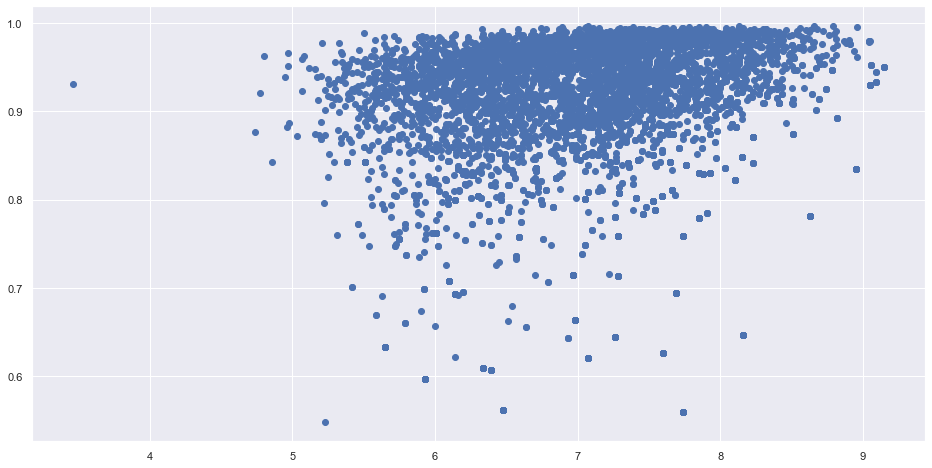

In [106]:
# Plot the Raw Data on a 2D grid
f, axes = plt.subplots(1, 1, figsize=(16,8))
plt.scatter(x = "mean", y = "positive_viewership_fraction", data = X_train)

## Nearest Neighbors (k-NN) - `LocalOutlierFactor`

Use the Nearest Neighbors (k-NN) pattern-identification method for detecting Outliers and Anomalies.    
We will use the `LocalOutlierFactor` neighborhood model from `sklearn.neighbors` module.

In [107]:
# Import LocalOutlierFactor from sklearn.neighbors
from sklearn.neighbors import LocalOutlierFactor

# Set the Parameters for Neighborhood
num_neighbors = 40      # Number of Neighbors
cont_fraction = 0.02    # Fraction of Anomalies

# Create Anomaly Detection Model using LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors = num_neighbors, contamination = cont_fraction)

# Fit the Model on the Data and Predict Anomalies
lof.fit(X_train)

LocalOutlierFactor(contamination=0.02, n_neighbors=40)

#### Labeling the Anomalies in the Data

We may use the model on the data to `predict` the anomalies.

<AxesSubplot:xlabel='Anomaly', ylabel='count'>

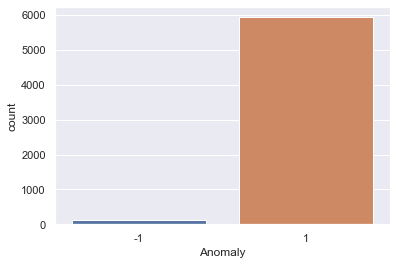

In [108]:
# Predict the Anomalies
labels = lof.fit_predict(X_train)

# Append Labels to the Data
X_train_labeled = X_train.copy()
X_train_labeled["Anomaly"] = pd.Categorical(labels)

# Summary of the Anomaly Labels
sb.countplot(X_train_labeled["Anomaly"])

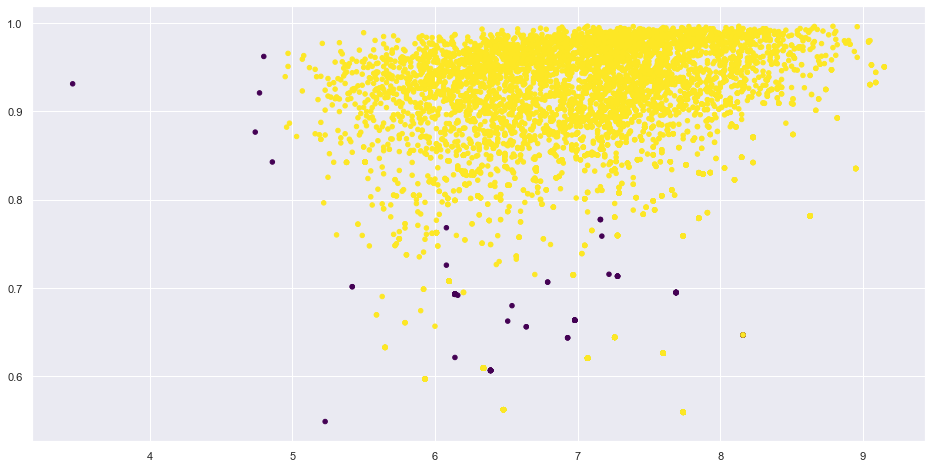

In [114]:
# Sample 1000 random lines
# df_sample=data_labeled.sample(1000)

# Visualize the Anomalies in the Data
f, axes = plt.subplots(1, 1, figsize=(16,8))
plt.scatter(x = "mean", y = "positive_viewership_fraction", c = "Anomaly", cmap = 'viridis', data = X_train_labeled, s=20)

### Interpret the Anomalies

Try to interpret the anomalies by exploring the Features across them.

<AxesSubplot:xlabel='positive_viewership_fraction', ylabel='Anomaly'>

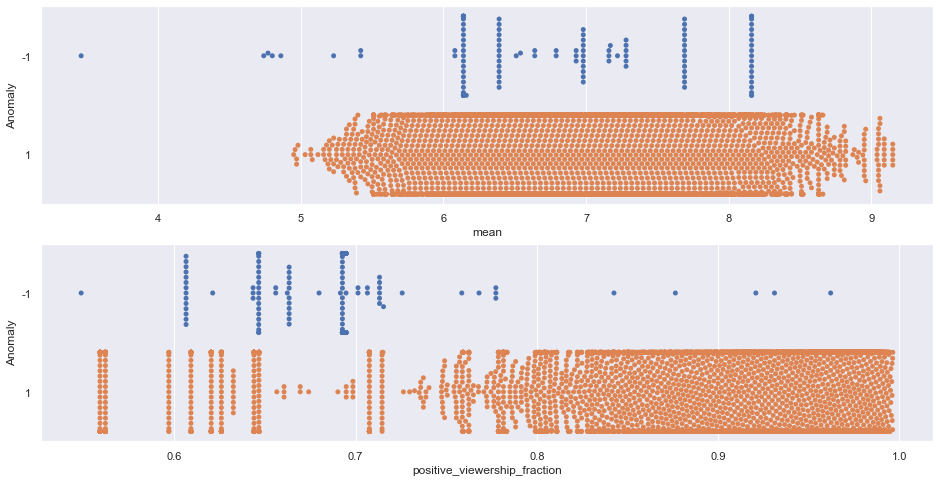

In [115]:
# Boxplots for the Features for the Anomalies
f, axes = plt.subplots(2, 1, figsize=(16,8))
sb.swarmplot(x = 'mean', y = 'Anomaly', data = X_train_labeled, ax = axes[0])
sb.swarmplot(x = 'positive_viewership_fraction', y = 'Anomaly', data = X_train_labeled, ax = axes[1])

**Interpretation:**
- It looks like `mean` < 5 can be considered an anomaly

---

## Multi-Variate Anomaly Detection
 
Features : **`mean`, `positive_viewership_fraction`, `synopsis_length`, `average_episode_duration`, `num_episodes`** 

Categorical Features: **`media_type`, `source`, `start_season_season`, `broadcast_day_of_the_week`**

In [121]:
# Import Libraries
from sklearn.model_selection import train_test_split

# Extract the Features from the Data
X = pd.DataFrame(anime_df[[
    "mean", "positive_viewership_fraction", "synopsis_length", 
    #"media_type", "source", "start_season_season", "broadcast_day_of_the_week", 
    "average_episode_duration", "num_episodes"
]]) 

# Split the Dataset into Train and Test
X_train, X_test = train_test_split(X, test_size = 0.3)

print("Length")
print(f"X_train:\t {len(X_train)}")
print(f"X_test: \t {len(X_test)}")

Length
X_train:	 6062
X_test: 	 2599


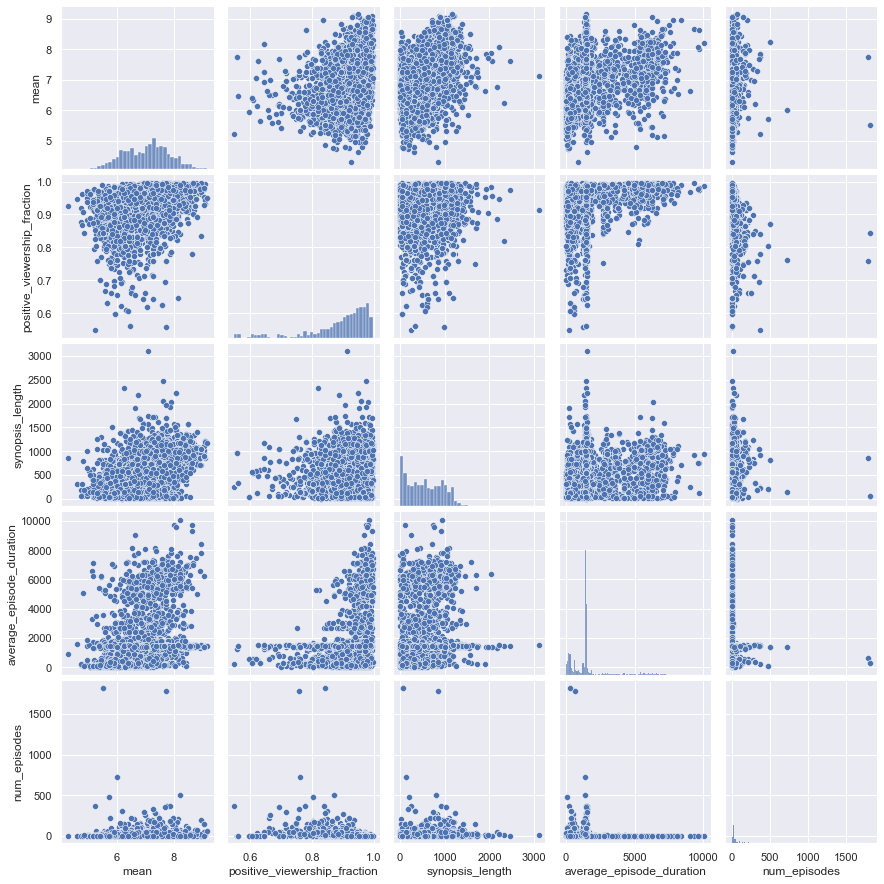

In [123]:
# Plot the Raw Data on 2D grids
sb.pairplot(X_train)

In [124]:
# Import LocalOutlierFactor from sklearn.neighbors
from sklearn.neighbors import LocalOutlierFactor

# Set the Parameters for Neighborhood
num_neighbors = 40      # Number of Neighbors
cont_fraction = 0.02    # Fraction of Anomalies

# Create Anomaly Detection Model using LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors = num_neighbors, contamination = cont_fraction)

# Fit the Model on the Data and Predict Anomalies
lof.fit(X_train)

LocalOutlierFactor(contamination=0.02, n_neighbors=40)

<AxesSubplot:xlabel='Anomaly', ylabel='count'>

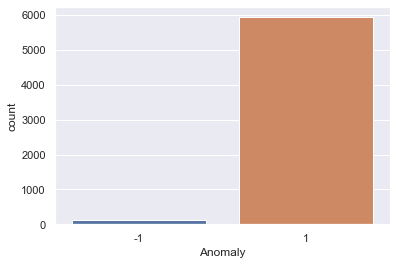

In [125]:
# Predict the Anomalies
labels = lof.fit_predict(X_train)

# Append Labels to the Data
X_train_labeled = X_train.copy()
X_train_labeled["Anomaly"] = pd.Categorical(labels)

# Summary of the Anomaly Labels
sb.countplot(X_train_labeled["Anomaly"])

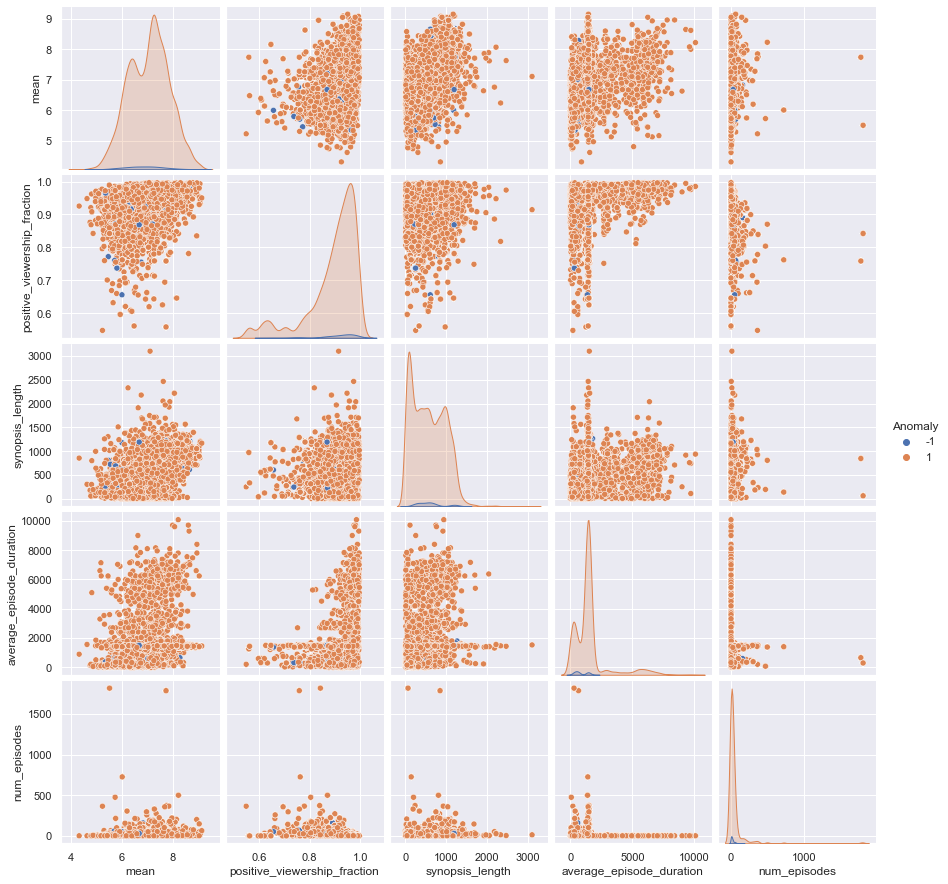

In [126]:
# Visualize the Anomalies in the Data
sb.pairplot(X_train_labeled, vars = X_train.columns.values, hue = "Anomaly")

<AxesSubplot:xlabel='num_episodes', ylabel='Anomaly'>

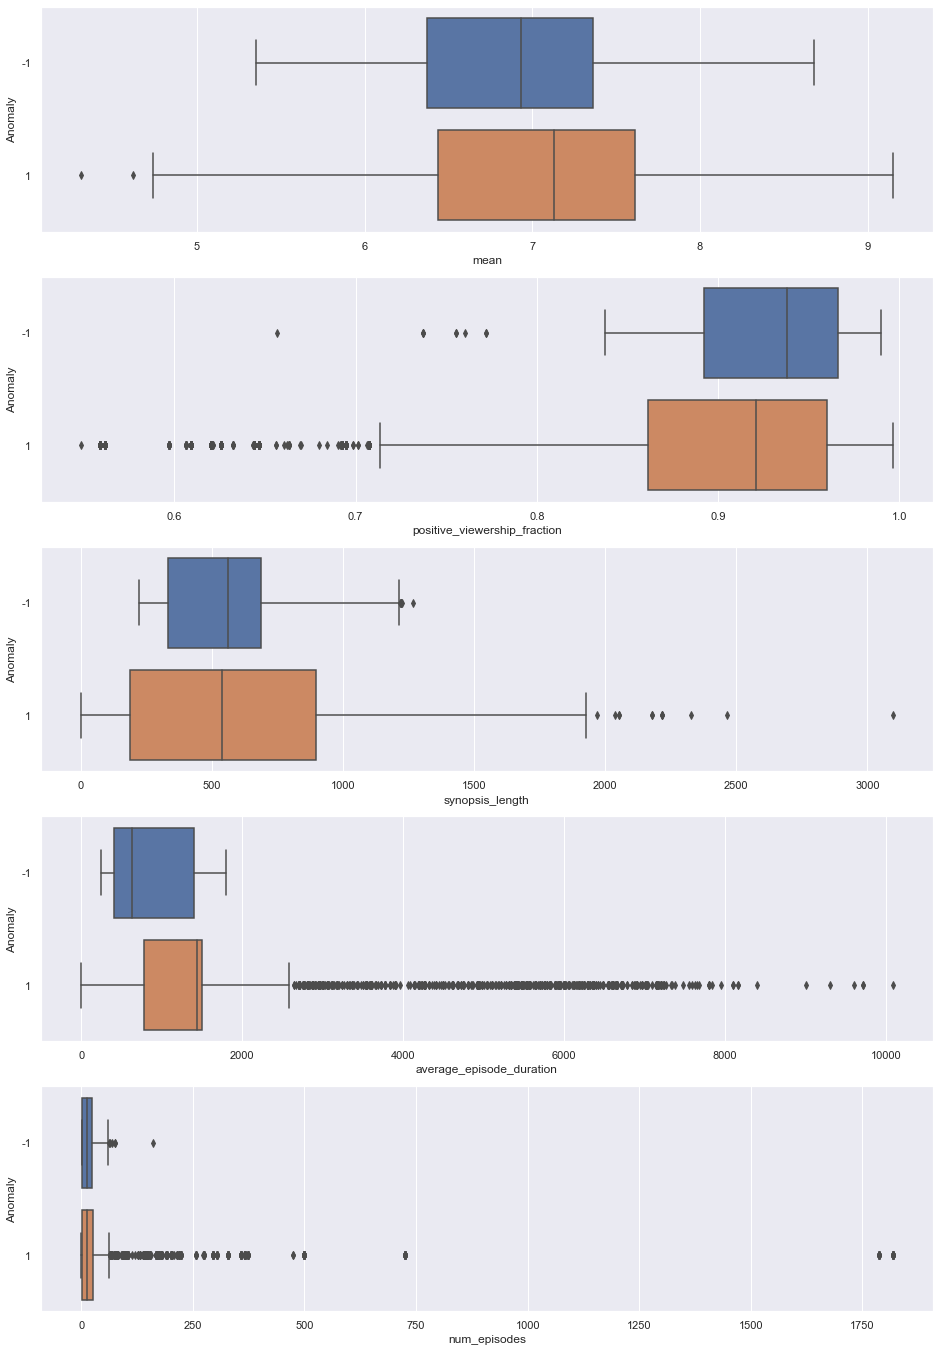

In [127]:
# Boxplots for all Features against the Anomalies
f, axes = plt.subplots(5, 1, figsize=(16,24))
sb.boxplot(x = 'mean', y = 'Anomaly', data = X_train_labeled, ax = axes[0])
sb.boxplot(x = 'positive_viewership_fraction', y = 'Anomaly', data = X_train_labeled, ax = axes[1])
sb.boxplot(x = 'synopsis_length', y = 'Anomaly', data = X_train_labeled, ax = axes[2])
sb.boxplot(x = 'average_episode_duration', y = 'Anomaly', data = X_train_labeled, ax = axes[3])
sb.boxplot(x = 'num_episodes', y = 'Anomaly', data = X_train_labeled, ax = axes[4])


- https://medium.com/balabit-unsupervised/how-to-evaluate-unsupervised-anomaly-detection-for-user-behavior-analytics-88f3d5de2018
- https://scikit-learn.org/stable/modules/outlier_detection.html#outlier-detection
- https://machinelearningmastery.com/model-based-outlier-detection-and-removal-in-python/